In [27]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm



matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
EXPERIMENT_NAME = 'Experiment_template'

## Set configuration

In [29]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg
cfg.use_default_data = True
cfg.saved_index=10

## Obtain Data
Obtain the simulated $y$ and $f$

Theoretical optimal mse for f, y, enc: 1259.397
Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=50, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=50, out_features=100, bias=True)
    (activation_1): Identity()
  )
)
(8192, 100) (1024, 100) (7168, 100)


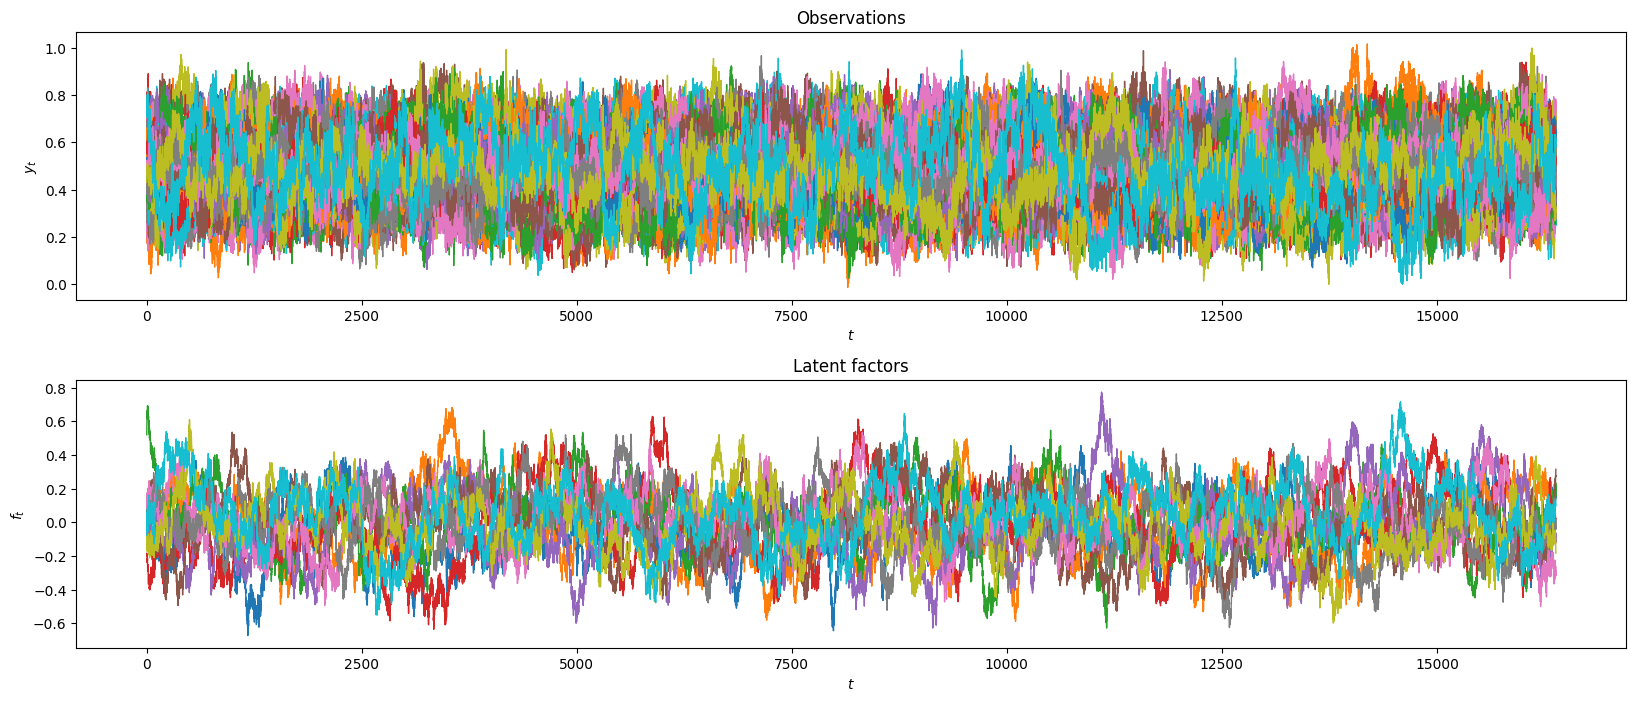

In [35]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim,5, 10,20,40,50,60,70,80,90, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=True, use_xavier=True)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [25]:
##torch.save(dec, '../DGP/saved/dec_4.pt')
#np.save(arr=y, file='../DGP/saved/y_4.npy')
#np.save(arr=f, file='../DGP/saved/f_4.npy')

In [50]:
from tqdm import tqdm
import math
def benchmarkExpandingWindowForecastPCA(y_train,y_test, T_max = math.inf):
    y_train = np.copy(y_train)
    y_test= np.copy(y_test)

    T = min(y_test.shape[0], T_max)
    pred = []
    for t in tqdm(range(T)):
        mod = PCA(n_components=cfg.factor_dim)
        f_train_hat = mod.fit_transform(y_train)
        f_test_hat = mod.transform(y_test)

        factorModel = VAR(f_train_hat)
        res = factorModel.fit(maxlags=1, ic='aic')
        test_model = VAR(np.concatenate([f_train_hat, f_test_hat[[0]]]))
        f_test_pred = test_model.predict(res.params, lags=res.k_ar)[[-1]]
        y_test_pred = mod.inverse_transform(f_test_pred)
        pred.append(y_test_pred)
        
        y_train = np.concatenate([y_train, y_test[[0]]])
        y_test = y_test[1:]
        
    return pred


### PCA

cc on train data: 0.9374820078338152
mse on train data: 0.009360289201140404
cc on test data: 0.8378319664441751
1-step ahead  FMSE on the test set: 0.009825155653829642


100%|█████████████████████████████████████████| 200/200 [00:15<00:00, 12.57it/s]


Expanding window msfe: 0.009400419177195305


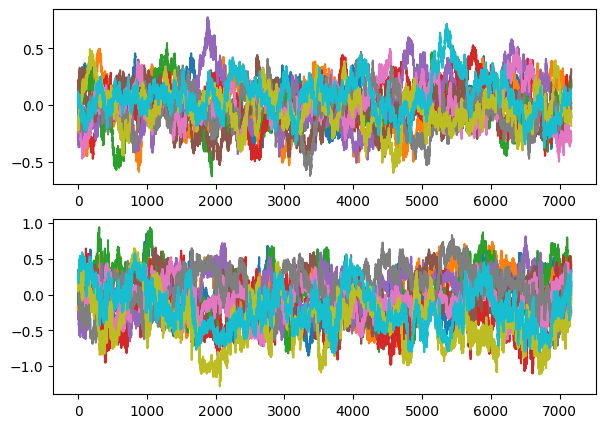

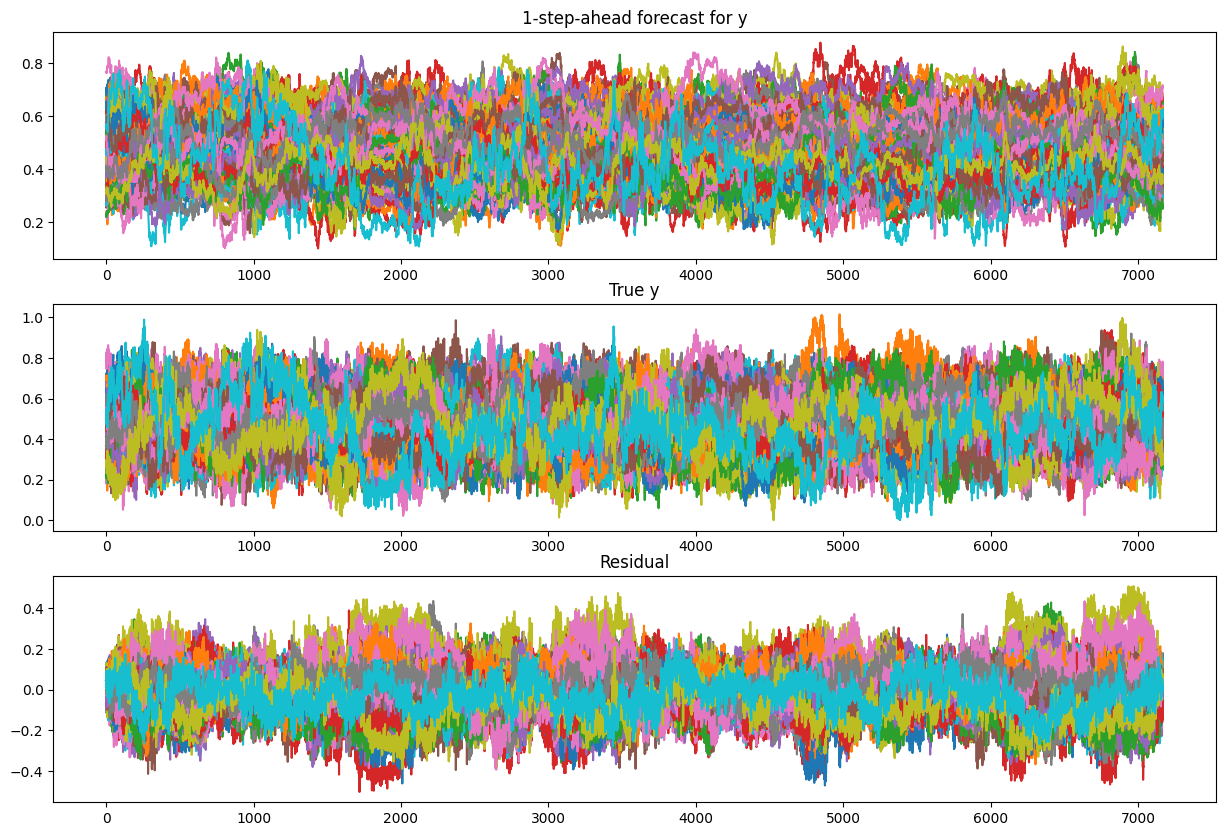

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_train_hat = pca.fit_transform(y_train)
f_val_hat = pca.fit_transform(y_val)
cancorr = CanCorr(f_train_hat, f_train)
y_test_hat = pca.inverse_transform(f_test_hat)
mse = np.mean((y_test_hat-y_test)**2)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
print(f"mse on train data: {mse}")

f_test_hat = pca.transform(y_test)
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

cca = CCA(n_components=cfg.factor_dim, scale=False)
cca.fit(f_train_hat, f_train)
fig,ax = plt.subplots(2,1, figsize=(7,5))
ax[0].plot(f_test);
ax[1].plot(cca.predict(f_test_hat));

f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = pca.inverse_transform(f_test_pred)

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")




y_test_pred = benchmarkExpandingWindowForecastPCA(np.concatenate([y_train,y_val]), y_test, T_max=200)
print(f'Expanding window msfe: {np.mean((y_test_pred - y_test[:100])**2)}')


In [61]:
mod = sm.tsa.DynamicFactor(endog=y_train[0:100], k_factors=cfg.factor_dim, factor_order=1, error_order=0)
#initial_res = mod.fit(method='powell', disp=True)
#res = mod.fit(initial_res.params, disp=True)
res = mod.fit( disp=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14133D+03    |proj g|=  2.80800D+04


 This problem is unconstrained.



At iterate    1    f=  8.66009D+02    |proj g|=  1.09226D+03

At iterate    2    f=  7.26117D+02    |proj g|=  7.17318D+02

At iterate    3    f=  3.66385D+02    |proj g|=  2.84466D+02

At iterate    4    f=  1.43090D+02    |proj g|=  1.01889D+02

At iterate    5    f=  5.12890D+00    |proj g|=  1.46526D+02

At iterate    6    f= -1.07688D+01    |proj g|=  3.25467D+02

At iterate    7    f= -3.97865D+01    |proj g|=  8.06614D+01

At iterate    8    f= -4.94777D+01    |proj g|=  3.81086D+01

At iterate    9    f= -5.77091D+01    |proj g|=  2.37502D+01

At iterate   10    f= -6.66787D+01    |proj g|=  4.63356D+01

At iterate   11    f= -7.27696D+01    |proj g|=  7.89750D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


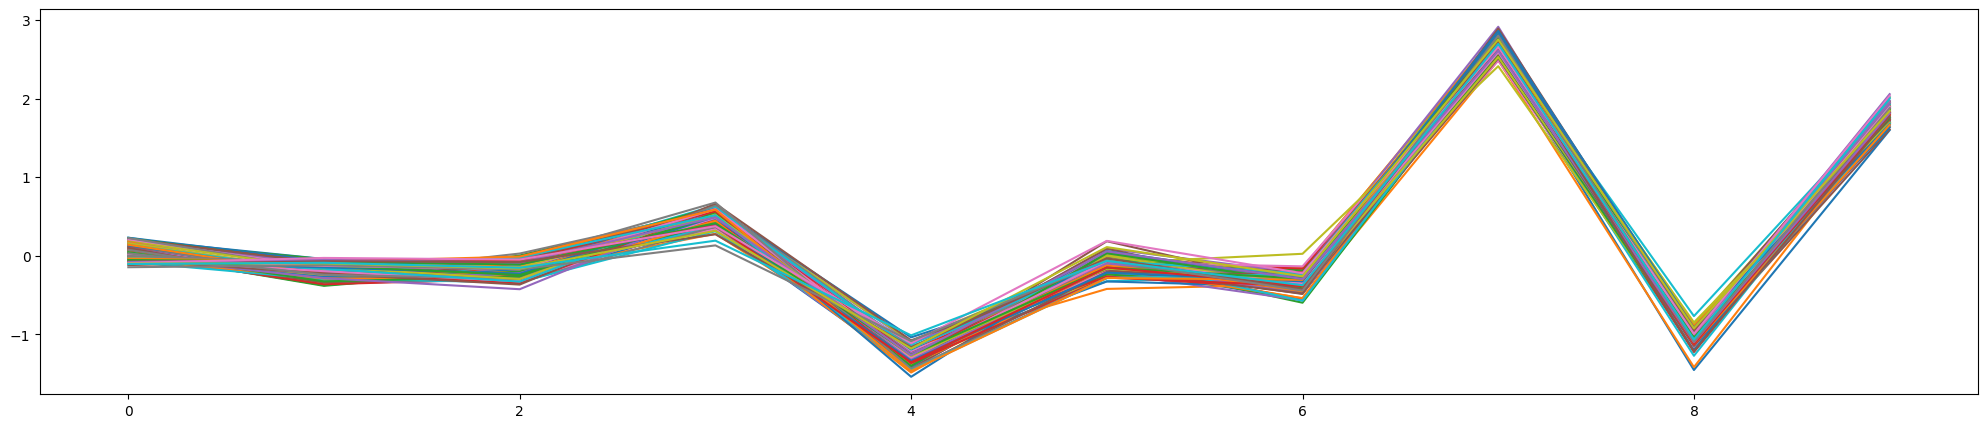

In [63]:
plt.plot(res.factors['filtered'])

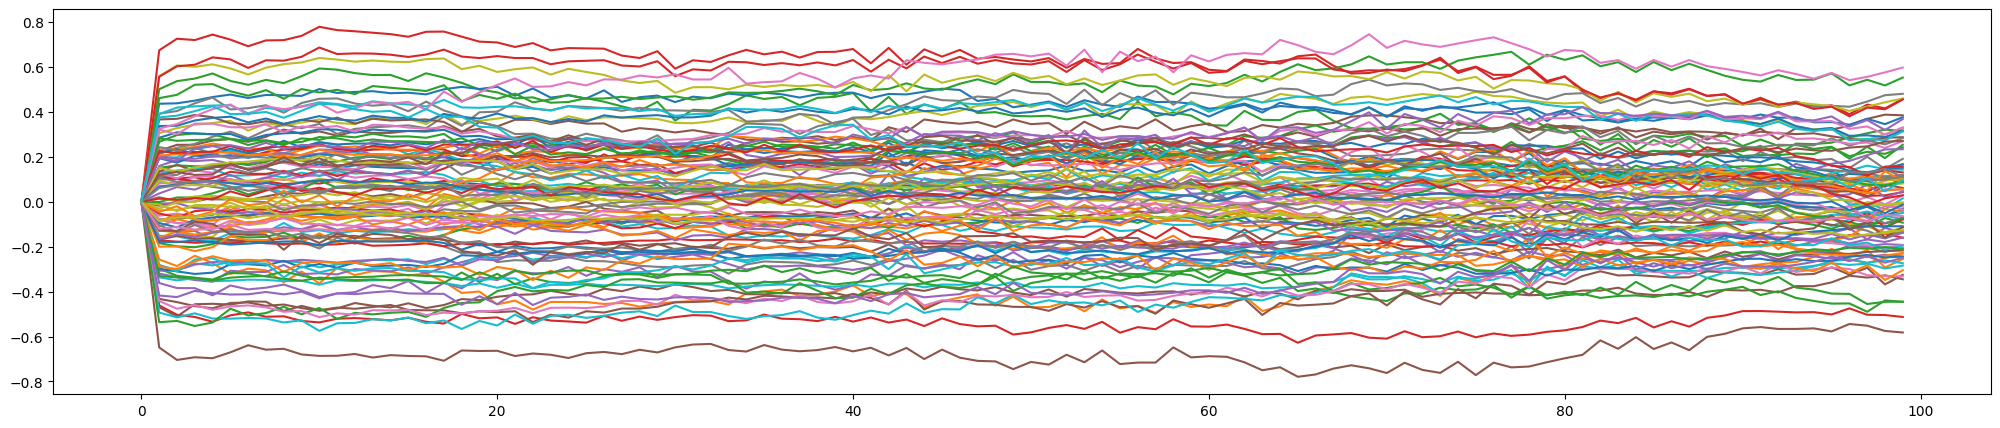

In [77]:
plt.plot(res.predict());

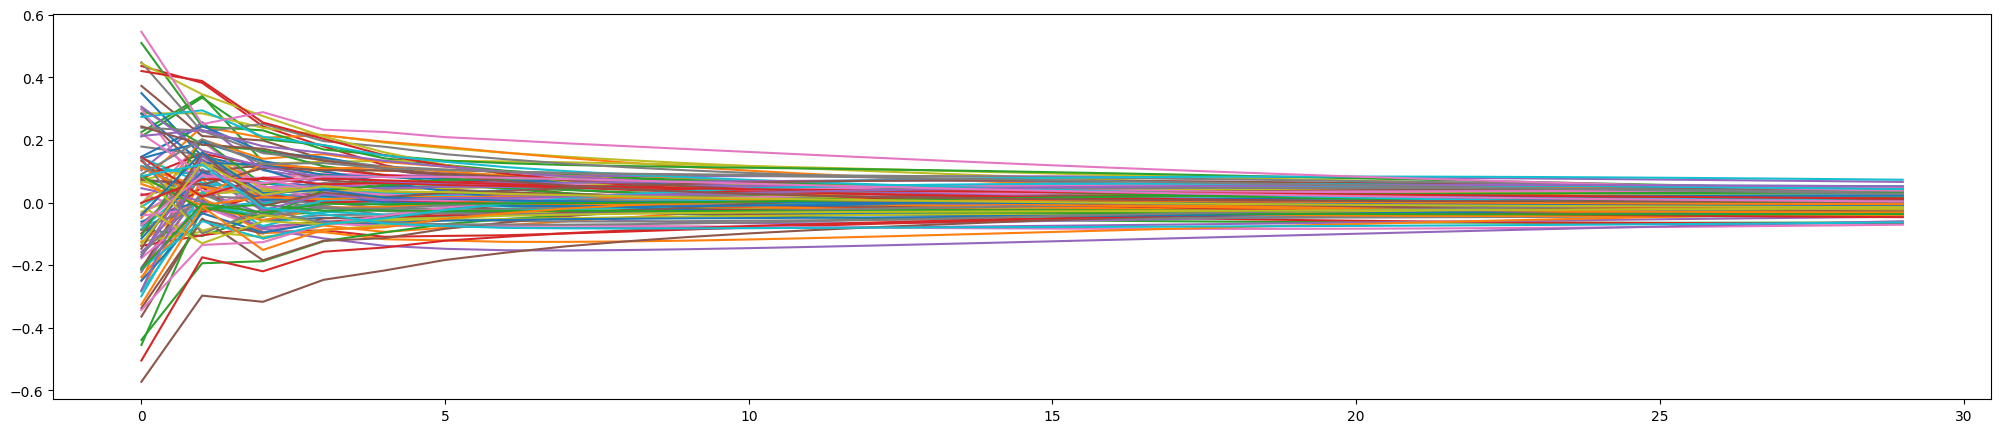

In [80]:
plt.plot(res.forecast(steps=30));